# BrightApps Assignment Problem
## Table of Contents:
* [Data Understanding](#data-understanding)
* [Feature Importance](#feature-importance)
* [Outlier Detection](#outlier-detection)
* [Feature Engineering](#feature-engineering)
* [Model Building](#model-building)
* [Summary Recap](#summary-recap)

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from scipy.stats import shapiro, normaltest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

alpha = .05 # statistical testing level
N = 10_0000 # reduced data regime

# Data Understanding <a class="anchor" id="data-understanding"></a>
Familiarize yourself with the dataset and interpret the significance of each feature.

In [2]:
df = pd.read_csv('./data.csv')

In [3]:
# long and skinny
df.shape

(281004, 15)

In [4]:
df.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,label
0,0.860224,1.0,0.905699,0.0,0.000000,0.897801,0.416134,0.936249,0.954516,0.655994,70.0,0.904535,0.477965,1.000000,1
1,0.899660,0.0,0.950384,0.0,0.000000,0.899660,0.814271,0.965632,0.895718,0.866131,36.0,0.726427,0.770299,1.000000,1
2,0.604478,0.0,0.901425,0.0,0.544263,0.816494,0.542276,0.929602,0.982845,0.943498,106.0,0.855471,0.602923,0.670886,1
3,0.786914,0.0,0.874471,0.0,0.000000,0.767869,0.792423,0.901341,0.815631,0.793568,135.0,0.843382,1.000000,1.000000,1
4,0.485634,1.0,0.909619,0.5,0.000000,0.499489,1.000000,0.644051,0.890473,0.998848,0.0,0.825947,1.000000,0.000000,1


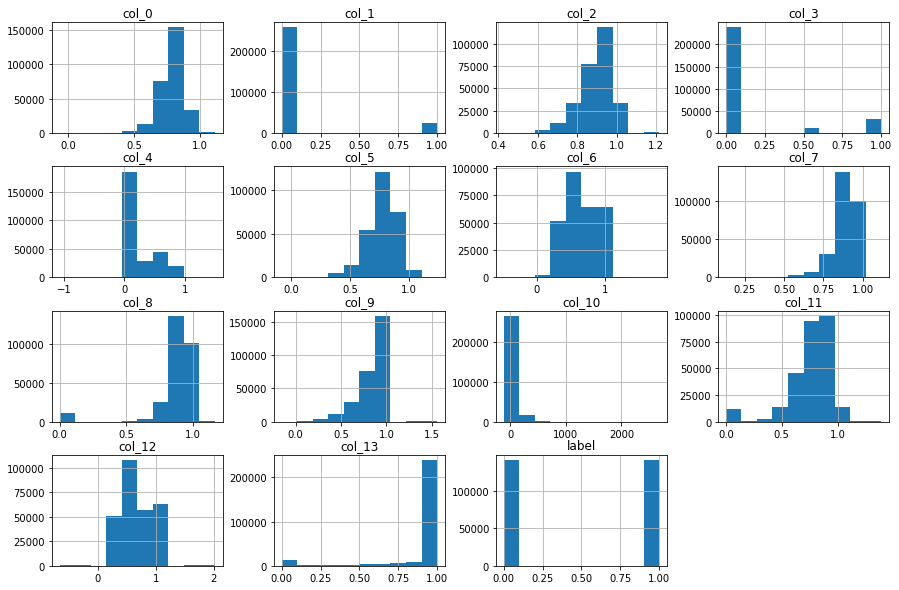

In [5]:
df.hist(figsize=(15,10));

- Target classes look balanced
- Many of these distributions are squashed by outliers

In [6]:
from enum import Enum

class ColumnDistribution(Enum):
    BINARY = 0
    CATEGORICAL = 1
    CONTINUOUS = 2
    
def col_binary_categorical_cont(s:pd.Series, max_categories=20):
    lvc = len(s.value_counts())
    if lvc == 2: return ColumnDistribution.BINARY
    if lvc < max_categories: return ColumnDistribution.CATEGORICAL
    else: return ColumnDistribution.CONTINUOUS

column_distributions = df.apply(col_binary_categorical_cont)
column_distributions

col_0      ColumnDistribution.CONTINUOUS
col_1          ColumnDistribution.BINARY
col_2      ColumnDistribution.CONTINUOUS
col_3     ColumnDistribution.CATEGORICAL
col_4      ColumnDistribution.CONTINUOUS
col_5      ColumnDistribution.CONTINUOUS
col_6      ColumnDistribution.CONTINUOUS
col_7      ColumnDistribution.CONTINUOUS
col_8      ColumnDistribution.CONTINUOUS
col_9      ColumnDistribution.CONTINUOUS
col_10     ColumnDistribution.CONTINUOUS
col_11     ColumnDistribution.CONTINUOUS
col_12     ColumnDistribution.CONTINUOUS
col_13     ColumnDistribution.CONTINUOUS
label          ColumnDistribution.BINARY
dtype: object

In [7]:
# Binary labels
df.label.unique()

array([1, 0])

In [8]:
# No Nulls -- probably pre-cleaned
df.isnull().sum(axis=0)/len(df)

col_0     0.0
col_1     0.0
col_2     0.0
col_3     0.0
col_4     0.0
col_5     0.0
col_6     0.0
col_7     0.0
col_8     0.0
col_9     0.0
col_10    0.0
col_11    0.0
col_12    0.0
col_13    0.0
label     0.0
dtype: float64

In [9]:
# Test for all-zero columns (it happens!)
any(df.sum() == 0)

False

In [10]:
df.describe()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,label
count,281004.000000,281004.000000,281004.000000,281004.000000,281004.000000,281004.000000,281004.000000,281004.000000,281004.000000,281004.000000,281004.000000,281004.000000,281004.000000,281004.000000,281004.000000
mean,0.786245,0.085977,0.892915,0.132527,0.195575,0.773967,0.653034,0.884875,0.861789,0.863303,58.644184,0.758937,0.660080,0.914492,0.500160
std,0.089018,0.280331,0.083577,0.323653,0.303187,0.125954,0.248056,0.072949,0.190076,0.171181,67.475896,0.209225,0.257984,0.236541,0.500001
min,-0.063343,0.000000,0.427709,0.000000,-1.075384,-0.079069,-0.488159,0.128208,0.000000,-0.152368,-112.486216,0.000000,-0.649736,0.000000,0.000000
25%,0.738787,0.000000,0.848364,0.000000,0.000000,0.705784,0.464633,0.857066,0.856616,0.774144,20.000000,0.688354,0.461148,1.000000,0.000000
50%,0.796567,0.000000,0.908683,0.000000,0.000000,0.789394,0.626251,0.903768,0.912699,0.922107,42.000000,0.802971,0.628400,1.000000,1.000000
75%,0.846311,0.000000,0.953914,0.000000,0.434253,0.859719,0.849837,0.932482,0.945720,0.998507,73.000000,0.890945,0.910616,1.000000,1.000000
max,1.112313,1.000000,1.214537,1.000000,1.505117,1.240419,1.799994,1.119058,1.166633,1.559296,2676.000000,1.391272,2.020270,1.000000,1.000000


In [11]:
# Everything appears normalized except column 10
# Let's go ahead and normalize it
df['col_10'] = (df.col_10 - df.col_10.mean())/df.col_10.std()

In [12]:
# Shapiro-Wilk Test for statistical normality
dict(zip(df.columns, [['non-normal', 'normal'][bool(alpha < shapiro(df[col]).pvalue)] for col in df.columns]))

/Users/six/envs/stacked/lib/python3.8/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


{'col_0': 'non-normal',
 'col_1': 'non-normal',
 'col_2': 'non-normal',
 'col_3': 'non-normal',
 'col_4': 'non-normal',
 'col_5': 'non-normal',
 'col_6': 'non-normal',
 'col_7': 'non-normal',
 'col_8': 'non-normal',
 'col_9': 'non-normal',
 'col_10': 'non-normal',
 'col_11': 'non-normal',
 'col_12': 'non-normal',
 'col_13': 'non-normal',
 'label': 'non-normal'}

- Shapiro-Wilk test claims that none of these columns were drawn from a gaussian distribution.
- Higher the p-value, the more likely the column sample comes from a gaussian.
- We'll look at one more test just to make sure

In [13]:
# D’Agostino’s K^2 Test ("normaltest" in scipy) of statistical normality
dict(zip(df.columns, [['non-normal', 'normal'][bool(alpha < normaltest(df[col]).pvalue)] for col in df.columns]))

{'col_0': 'non-normal',
 'col_1': 'non-normal',
 'col_2': 'non-normal',
 'col_3': 'non-normal',
 'col_4': 'non-normal',
 'col_5': 'non-normal',
 'col_6': 'non-normal',
 'col_7': 'non-normal',
 'col_8': 'non-normal',
 'col_9': 'non-normal',
 'col_10': 'non-normal',
 'col_11': 'non-normal',
 'col_12': 'non-normal',
 'col_13': 'non-normal',
 'label': 'non-normal'}

- Both tests agree that these are not normal variables
- This will limit our approach to modeling

In [14]:
target = df['label']
del df['label']

## Data Understanding Summary
- Dataset is long and skinny
- Appears normalized other than column 10, so normalize it.
- No missing values
- No all-zero columns
- Columns are *not* normally distributed
- No columnar colinearity
- Target correlations look well-formed

# Outlier Detection <a class="anchor" id="outlier-detection"></a>
Can you identify outliers in the dataset? What techniques do you use to identify these outliers, and how would you handle them?

----------

- Due to the non-normality of the data, the standard mean, stddev approach will be avoided in favor of a quantile-based approach.
- Handle by replacing high or low outliers with their upper or lower quantile respectively.

In [15]:
[(col, df[col].quantile(.01), df[col].quantile(.99)) for col in df.columns]

[('col_0', 0.5134994439, 0.9452360014899999),
 ('col_1', 0.0, 1.0),
 ('col_2', 0.633925901087379, 1.0),
 ('col_3', 0.0, 1.0),
 ('col_4', 0.0, 0.9244941075099995),
 ('col_5', 0.3943825634141313, 1.0),
 ('col_6', 0.18468812471, 1.0),
 ('col_7', 0.614496592, 0.97115236728),
 ('col_8', 0.0, 0.978920528),
 ('col_9', 0.326004505, 0.999264452),
 ('col_10', -0.8691130789384277, 3.8733211805354832),
 ('col_11', 0.0, 1.0),
 ('col_12', 0.210828195, 1.0),
 ('col_13', 0.0, 1.0)]

In [16]:
# Quantile based outlier detection and handling
low = .01
high = .99
dq = dict() # dictionary of quantiles
for col in df.columns:
    dq[(col, 'low')]  = df[col].quantile(low)
    dq[(col, 'high')] = df[col].quantile(high)
    # Detection
    print(
        col,
        ((df[col] < dq[(col, 'low')]) | (dq[(col, 'high')] < df[col])).sum()
        , '# outliers')
    # Handling
    df[col] = df[col].apply(
        lambda x: x
        if (dq[(col, 'low')] <= x and x<=dq[(col, 'high')]) \
        else (dq[(col, 'high')] if x>dq[(col, 'high')] else dq[(col, 'low')])
    )

col_0 5622 # outliers
col_1 0 # outliers
col_2 3770 # outliers
col_3 0 # outliers
col_4 3827 # outliers
col_5 3788 # outliers
col_6 3803 # outliers
col_7 5621 # outliers
col_8 2811 # outliers
col_9 5129 # outliers
col_10 3827 # outliers
col_11 997 # outliers
col_12 3790 # outliers
col_13 0 # outliers


In [17]:
# Rerun detection to verify outliers have been handled
for col in df.columns:
    print(
        col,
        ((df[col] < dq[(col, 'low')]) | (dq[(col, 'high')] < df[col])).sum()
        , '# outliers')

col_0 0 # outliers
col_1 0 # outliers
col_2 0 # outliers
col_3 0 # outliers
col_4 0 # outliers
col_5 0 # outliers
col_6 0 # outliers
col_7 0 # outliers
col_8 0 # outliers
col_9 0 # outliers
col_10 0 # outliers
col_11 0 # outliers
col_12 0 # outliers
col_13 0 # outliers


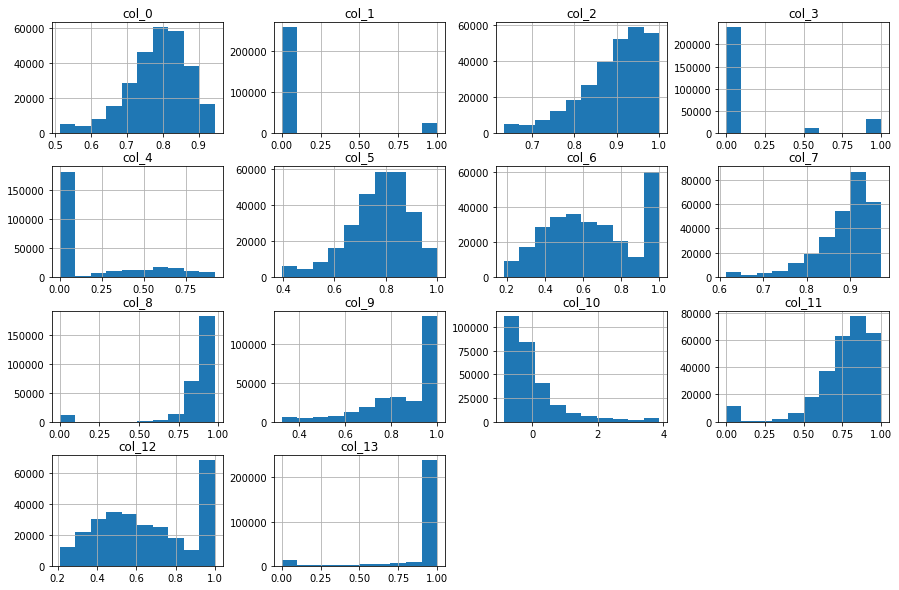

In [18]:
df.hist(figsize=(15,10));

## Outlier Detection Summary
- Removing the outliers definitely helps unsquash the distributions

# Feature Importance <a class="anchor" id="feature-importance"></a>
Identify the essential features in the dataset. What makes these features significant? How do they influence the outcome variable?

In [19]:
rank = np.linalg.matrix_rank(df)
{'matrix rank:':rank,
 'num cols:':df.shape[1],
 'superflous_cols:':df.shape[1] - rank}

{'matrix rank:': 14, 'num cols:': 14, 'superflous_cols:': 0}

In [20]:
# Recall our correlation values
df.corrwith(target).sort_values(ascending=False)

col_6     0.419001
col_12    0.406758
col_3     0.280728
col_2     0.245197
col_9     0.212937
col_0     0.197812
col_1     0.178260
col_11    0.155775
col_8     0.110973
col_5     0.083907
col_4     0.043136
col_13   -0.031404
col_10   -0.036080
col_7    -0.080593
dtype: float64

In [21]:
# Recall our correlation values
df.corrwith(target, method='spearman').sort_values(ascending=False)

col_6     0.412108
col_12    0.401256
col_3     0.292964
col_2     0.266255
col_9     0.224945
col_0     0.215502
col_1     0.178260
col_11    0.155689
col_8     0.111913
col_5     0.095393
col_4     0.039003
col_10   -0.053015
col_13   -0.056589
col_7    -0.070437
dtype: float64

In [22]:
# Recall our correlation values
df.corrwith(target, method='kendall').sort_values(ascending=False)

/Users/six/envs/stacked/lib/python3.8/site-packages/scipy/stats/_stats_py.py:5283: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


col_6     0.342247
col_12    0.334438
col_3     0.288697
col_2     0.217659
col_9     0.184232
col_1     0.178260
col_0     0.175975
col_11    0.127260
col_8     0.091462
col_5     0.077902
col_4     0.035654
col_10   -0.043494
col_13   -0.054103
col_7    -0.057519
dtype: float64

In [23]:
import sklearn.feature_selection as fs

In [24]:
# Assign anova F score for the discrete target variable

f_classif_mdl = fs.f_classif(df, target)

scores_df = pd.DataFrame(df.columns, columns = ['feature'])
scores_df['classif_f_score'] = f_classif_mdl[0] 
scores_df['classif_f_p_values'] = f_classif_mdl[1]
scores_df['classif_f_sig?'] = scores_df['classif_f_p_values']<=0.05

scores_df

,feature,classif_f_score,classif_f_p_values,classif_f_sig?
0,col_0,11443.319807,0.000000e+00,True
1,col_1,9222.351806,0.000000e+00,True
2,col_2,17974.985000,0.000000e+00,True
3,col_3,24039.879856,0.000000e+00,True
4,col_4,523.849098,7.860091e-116,True
5,col_5,1992.393100,0.000000e+00,True
6,col_6,59838.442237,0.000000e+00,True
7,col_7,1837.123373,0.000000e+00,True
8,col_8,3503.718232,0.000000e+00,True
9,col_9,13346.425110,0.000000e+00,True


In [25]:
# Chi^2 can't handle negative values
# df.min() # uncomment to check that only column 10 has a negative min
min10 = df.col_10.min()
df['col_10'] = df.col_10 - min10

chi2_mdl = fs.chi2(df, target)

scores_df = pd.DataFrame(df.columns, columns = ['feature'])
scores_df['chi2_score'] = chi2_mdl[0]
scores_df['chi2_p_values'] = chi2_mdl[1]
scores_df['chi2_sig?'] = scores_df['chi2_p_values']<=0.05

scores_df

,feature,chi2_score,chi2_p_values,chi2_sig?
0,col_0,100.019329,1.509170e-23,True
1,col_1,8161.636722,0.000000e+00,True
2,col_2,124.164361,7.754669e-29,True
3,col_3,17504.095452,0.000000e+00,True
4,col_4,226.318389,3.786764e-51,True
5,col_5,38.069708,6.826172e-10,True
6,col_6,4219.670392,0.000000e+00,True
7,col_7,9.389556,2.182250e-03,True
8,col_8,144.368366,2.951575e-33,True
9,col_9,402.051546,1.969435e-89,True


In [26]:
# reduce column 10 back to original state
df['col_10'] = df.col_10 + min10

## Discretized Target Means
- In this section we will analyze the difference in feature means when label is 0 vs 1.

In [27]:
ix0 = (target==0) # index for binary target classes
ix1 = ~ix0
np.mean(ix0), np.mean(ix1)

(0.4998398599308195, 0.5001601400691805)

- Target variable 'label' is perfectly balanced.

In [28]:
# Means of all features when label == 0 (False) and label == 1 (True)
df.groupby(ix1).mean()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13
label,,,,,,,,,,,,,,
False,0.769718,0.035990,0.872862,0.041639,0.184505,0.763796,0.553865,0.890713,0.840219,0.827246,0.017308,0.725601,0.561398,0.921923
True,0.803180,0.135933,0.912584,0.223356,0.209705,0.784277,0.751900,0.879835,0.882290,0.897499,-0.045071,0.790171,0.758179,0.907066


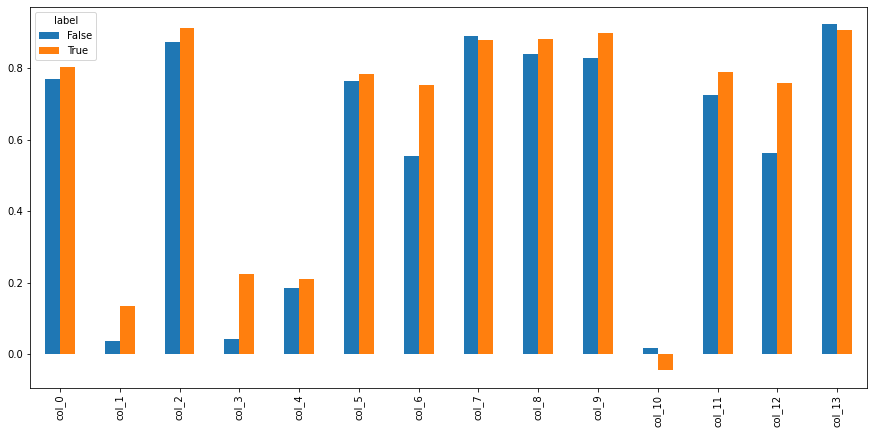

In [113]:
df.groupby(ix1).mean().transpose().plot(kind='bar', figsize=(15,7));

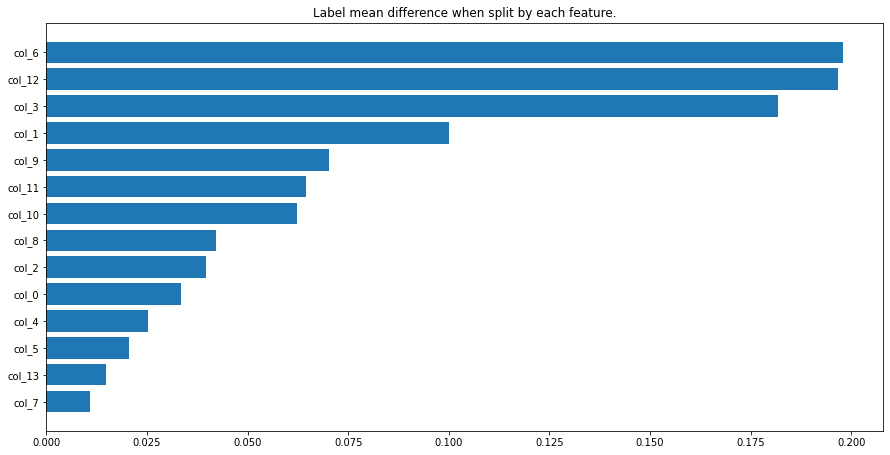

In [30]:
y_0_means = df.loc[ix0].mean()
y_1_means = df.loc[ix1].mean()

mean_diffs = (y_1_means - y_0_means).abs()
mean_diffs = mean_diffs.sort_values()

plt.figure(figsize=(15,7.5));
plt.barh(range(len(mean_diffs)), mean_diffs, tick_label=mean_diffs.index);
plt.title('Label mean difference when split by each feature.');

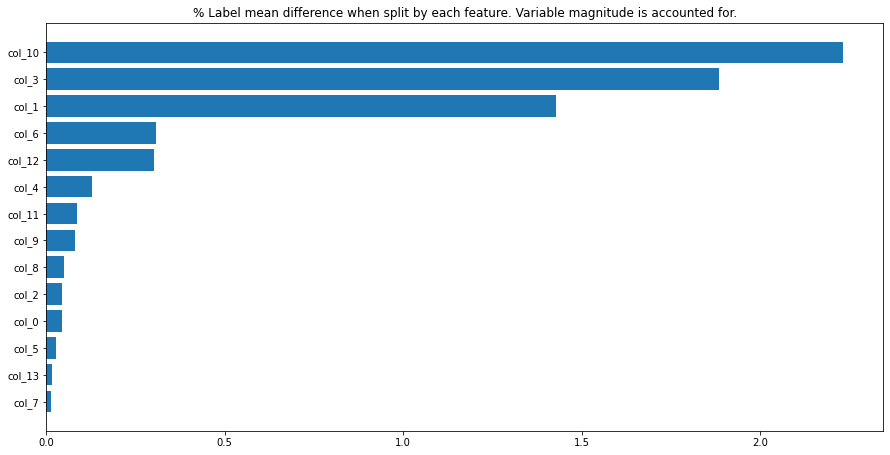

In [31]:
scales = 10**np.mean([np.log10(y_0_means.abs()), np.log10(y_1_means.abs())], axis=0)
mean_diffs = (y_1_means - y_0_means).abs()/scales
mean_diffs = mean_diffs.sort_values()

plt.figure(figsize=(15,7.5));
plt.barh(range(len(mean_diffs)), mean_diffs, tick_label=mean_diffs.index);
plt.title('% Label mean difference when split by each feature. Variable magnitude is accounted for.');

## Feature Selection Summary
- Identify the essential features in the dataset.
    - Top correlated and feature mean splits by target variable give a good indication, but this is ultimately decided by the top-performing models.
- What makes these features significant?
    - The rank of the matrix equals the number of features, meaning they're each distinct from one another.
    - Discrete versions of the Oneway Anova F and Chi^2 tests agree they are each significant relative to the target variable.
- How do they influence the outcome variable?
    - We saw the difference in feature means when the label == 0 vs label == 1.

# Model Building and Evaluation <a class="anchor" id="model-building"></a>
Build a predictive model using the dataset. Which model did you choose and why? How well does your model perform?

In [32]:
# Split data into training and test. 80/20 split
df_train, df_test, y_train, y_test = train_test_split(df, target, test_size=.20, shuffle=True)

## Model Selection
- As the data is non-normal, we will eschew models which rest upon assumptions of normality.
- As indicated in the feature selection section, the target classes present nice distributional separation ("splits") in the independent variables.
- Tree models both benefit from good splits and don't assume feature normality.
- Specifically we'll be comparing Random Forests vs Gradient Boosted Trees.

## Model Building
### In this section we'll look at:
- Baseline tree model performance
- Feature Engineering: feature convolvement improves model performance, we'll use this augmented dataset
- Model Selection: Choose between tree models
- Hyperparameter Tuning
- Model Evaluation

### Baseline model performance

In [104]:
rfc_model = RandomForestClassifier(n_jobs=-1) # TODO hyperparams

In [34]:
%%time
rfc_model.fit(df_train, y_train)

CPU times: user 2min 38s, sys: 1.73 s, total: 2min 39s
Wall time: 43.4 s


RandomForestClassifier(n_jobs=-1)

In [35]:
# Model r^2 Score
round(rfc_model.score(df_test, y_test), 3)

## Baseline: .730

0.73

In [102]:
N=10_000

In [105]:
%%time
rfc_model.fit(df_train[:N], y_train[:N])
round(rfc_model.score(df_test, y_test), 3)

CPU times: user 4.92 s, sys: 97.7 ms, total: 5.01 s
Wall time: 1.56 s


0.709

# Feature Engineering <a class="anchor" id="feature-engineering"></a>
How would you create new features from the existing ones to better capture the underlying patterns in the data?
- Convolving all 14 features with one another will yield 91 features
- We'll make a second dataset with less rows, and compare it to the original (scaled-down) dataset.

In [37]:
len(df.columns)

14

In [38]:
# 15 choose 2 + original 15 features
import scipy as sp
sp.special.comb(14, 2) + 14

105.0

In [39]:
from sklearn.preprocessing import PolynomialFeatures
poly_fs = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
N = 10_000
# df train "engineered"
df_train_eng = poly_fs.fit_transform(df_train[:100_000])
df_train_eng = pd.DataFrame(df_train_eng, columns=poly_fs.get_feature_names_out()) # Reformat

In [40]:
df_test_eng = poly_fs.fit_transform(df_test)
df_test_eng = pd.DataFrame(df_test_eng, columns=poly_fs.get_feature_names_out())

In [41]:
# Augmented training set
df_train_eng.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,col_10^2,col_10 col_11,col_10 col_12,col_10 col_13,col_11^2,col_11 col_12,col_11 col_13,col_12^2,col_12 col_13,col_13^2
0,0.780770,0.0,0.886988,0.0,0.000000,0.755750,0.240750,0.896739,0.858061,0.640383,...,0.826826,0.598540,0.297228,0.909300,0.433283,0.215164,0.658243,0.106848,0.326876,1.00000
1,0.787909,0.0,0.753728,0.0,0.503725,0.707453,0.424008,0.883280,0.930934,0.454047,...,0.068376,-0.212429,-0.167739,-0.261489,0.659965,0.521125,0.812382,0.411494,0.641478,1.00000
2,0.699486,0.0,0.908892,1.0,0.598551,0.781316,1.000000,0.877894,0.944873,0.998996,...,0.122787,-0.299592,-0.350409,-0.211454,0.730985,0.854976,0.515934,1.000000,0.603448,0.36415
3,0.945236,0.0,0.973960,0.5,0.000000,0.990412,1.000000,0.920124,0.866112,0.998507,...,0.082286,0.182919,0.286855,0.286855,0.406625,0.637672,0.637672,1.000000,1.000000,1.00000
4,0.774315,0.0,0.912153,0.0,0.877128,0.796313,0.581309,0.946191,0.928339,0.808453,...,0.058755,0.229726,0.151802,0.242395,0.898202,0.593528,0.947735,0.392200,0.626259,1.00000


In [42]:
%%time
# Compare Performance
rfc_model = RandomForestClassifier(n_jobs=-1)
rfc_model.fit(df_train_eng[:N], y_train[:N])
round(rfc_model.score(df_test_eng, y_test), 3)

CPU times: user 13.3 s, sys: 137 ms, total: 13.4 s
Wall time: 3.74 s


0.704

In [43]:
from sklearn.linear_model import LogisticRegression as LR
logistic_model = LR(n_jobs=-1)
logistic_model.fit(df_train[:N], y_train[:N])
logistic_model.score(df_test, y_test)

0.695307912670593

In [44]:
%%time
# augmented
logistic_model = LR(n_jobs=-1)
logistic_model.fit(df_train_eng[:10_000], y_train[:10_000])
logistic_model.score(df_test_eng, y_test)

CPU times: user 97 ms, sys: 37.5 ms, total: 134 ms
Wall time: 1.27 s


0.7009305884236935

In [45]:
from sklearn.linear_model import LassoCV
lasso = LassoCV()
# baseline
lasso.fit(df_train[:N], y_train[:N])
lasso.score(df_test, y_test)

0.21383657060678873

In [46]:
%%time
# augmented
lasso = LassoCV()
lasso.fit(df_train_eng[:100_000], y_train[:100_000])
lasso.score(df_test_eng, y_test)

/Users/six/envs/stacked/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.475591608810646, tolerance: 1.9999900987499972
  model = cd_fast.enet_coordinate_descent_gram(


CPU times: user 23.1 s, sys: 1.4 s, total: 24.5 s
Wall time: 12.7 s


/Users/six/envs/stacked/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.394e+02, tolerance: 2.500e+00
  model = cd_fast.enet_coordinate_descent(


0.23522538526416237

## Feature Engineering Summary
- We created an augmented dataset from engineered features of the form f1*f2, f2*f3, f1^2, f2^2 ...etc
- We went from a baseline dataset performance of .709, down to an augmented dataset performance of .705.
- Augmentation did not increase performance of tree models.
- Augmentation only of slightly marginal benefit for linear models.

In [47]:
# Free up the memory from the augmented set
del df_train_eng
del df_test_eng

### Model Selection: Choose between tree models

In [48]:
from sklearn.ensemble import GradientBoostingClassifier as GBT, HistGradientBoostingClassifier as HGBT

In [49]:
gbt_model  = GBT()
hgbt_model = HGBT()

In [50]:
%%time
hgbt_model.fit(df_train, y_train) # 10 seconds
hgbt_model.score(df_test, y_test)

CPU times: user 12.9 s, sys: 731 ms, total: 13.6 s
Wall time: 4.35 s


0.7228163199943062

In [51]:
%%time
# gbt_model.fit(df_train[:N], y_train[:N])
gbt_model.fit(df_train, y_train)
gbt_model.score(df_test, y_test)

CPU times: user 1min 32s, sys: 985 ms, total: 1min 33s
Wall time: 1min 33s


0.7167132257433142

### Model Selection Summary
- Going with the random forest, hgbt and logistic regression models due to:
    1. Have the highest overall performance
    2. Maintain performance in low-data regimes (r^2 of ~.70(rand forest and logreg) vs .43(gbt) on 10k samples)
2. Will become important in the next section on hyperparameter tuning.

# Hyperparameter Tuning <a class="anchor" id="hyperparameter-tuning"></a>
- We will make use of validation datasets in the form of *cross-validation* in this section.
- It will help us both optimize the hyperparamers while avoid overfitting to the training data.
- We will tune one tree and one linear model.
- Tuning will be done on a reduced N of 10k; testing will then be done on the full set with the optimal params.

In [52]:
# Recall we're searching on a reduced sample size
N

10000

In [53]:
from sklearn.model_selection import GridSearchCV

### Histogram Boosted Decision Tree HP Tuning

In [54]:
%%time
''' Histogram Boosted Decision Trees
learning_rate : float, default=0.1
    The learning rate, also known as *shrinkage*. This is used as a
    multiplicative factor for the leaves values. Use ``1`` for no
    shrinkage.
max_iter : int, default=100
    The maximum number of iterations of the boosting process, i.e. the
    maximum number of trees for binary classification. For multiclass
    classification, `n_classes` trees per iteration are built.
max_leaf_nodes : int or None, default=31
    The maximum number of leaves for each tree. Must be strictly greater
    than 1. If None, there is no maximum limit.
max_depth : int or None, default=None
    The maximum depth of each tree. The depth of a tree is the number of
    edges to go from the root to the deepest leaf.
    Depth isn't constrained by default.
min_samples_leaf : int, default=20
    The minimum number of samples per leaf. For small datasets with less
    than a few hundred samples, it is recommended to lower this value
    since only very shallow trees would be built.
'''
hgbt_params = {
    'learning_rate': [.1, .5]
    , 'max_iter': [100, 200]
    , 'max_leaf_nodes' : [10, 31]
    , 'max_depth': [None]
    , 'min_samples_leaf': [20, 40]
}
grid_search_hgbt = GridSearchCV(
    estimator=HGBT(),
    param_grid=hgbt_params,
    cv=2, n_jobs=-1, verbose=1, scoring="accuracy")
grid_search_hgbt.fit(df_train, y_train)

Fitting 2 folds for each of 16 candidates, totalling 32 fits
CPU times: user 18.9 s, sys: 1.23 s, total: 20.1 s
Wall time: 47.6 s


GridSearchCV(cv=2, estimator=HistGradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.5], 'max_depth': [None],
                         'max_iter': [100, 200], 'max_leaf_nodes': [10, 31],
                         'min_samples_leaf': [20, 40]},
             scoring='accuracy', verbose=1)

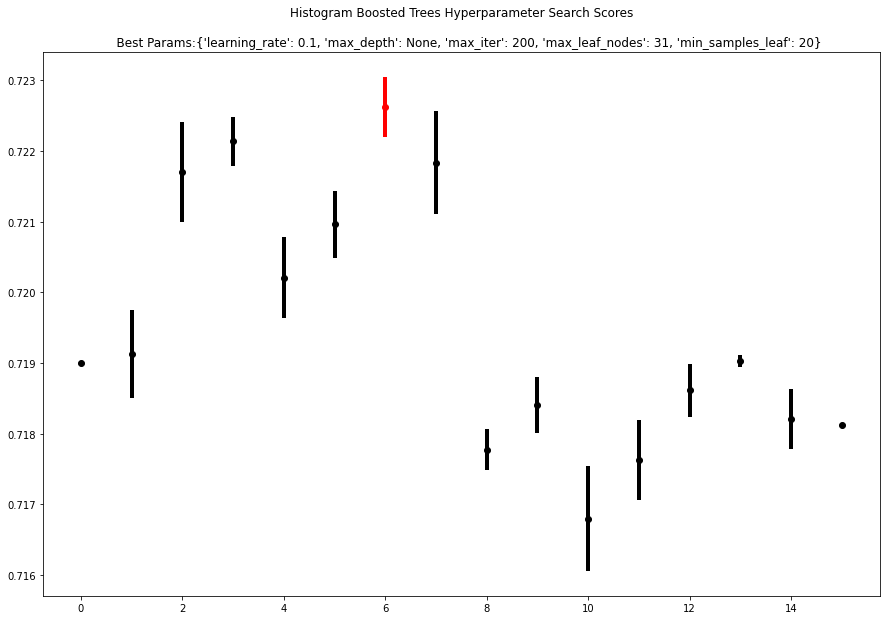

In [55]:
df_scores_hgbt = pd.DataFrame(grid_search_hgbt.cv_results_)

labels = np.arange(len(df_scores_hgbt))
legend = [str(v) for v in df_scores_hgbt.params.values]
stds = df_scores_hgbt.std_test_score
means = df_scores_hgbt.mean_test_score
ix_best_score = np.argmax(means)
plt.figure(figsize=(15,10));
for i in labels:
    if i == ix_best_score:
        plt.errorbar(labels[i], means[i], stds[i], fmt='or', lw=4)
    else:
        plt.errorbar(labels[i], means[i], stds[i], fmt='ok', lw=4)
plt.title(f'''Histogram Boosted Trees Hyperparameter Search Scores\n
    Best Params:{legend[ix_best_score]}''');

In [56]:
%%time
best_hgbt_params = df_scores_hgbt.params[np.argmax(means)]
print('best hgbt params', best_hgbt_params)
hgbt_model = HGBT(**best_hgbt_params)
hgbt_model.fit(df_train, y_train)
hgbt_model.score(df_test, y_test)

best hgbt params {'learning_rate': 0.1, 'max_depth': None, 'max_iter': 200, 'max_leaf_nodes': 31, 'min_samples_leaf': 20}
CPU times: user 21.7 s, sys: 1.31 s, total: 23 s
Wall time: 7.02 s


0.7243999217095781

In [57]:
df_scores_hgbt = pd.concat([
    df_scores_hgbt,
    pd.DataFrame.from_records(df_scores_hgbt.params.values, index=df_scores_hgbt.index)
], axis=1)

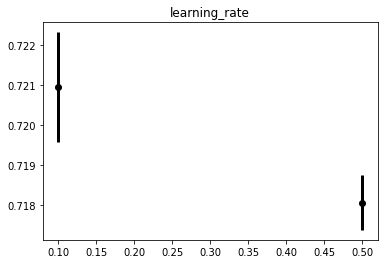

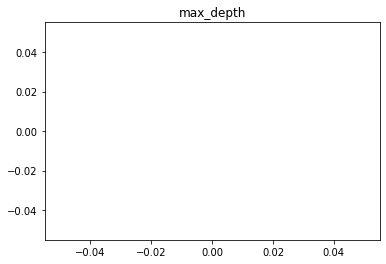

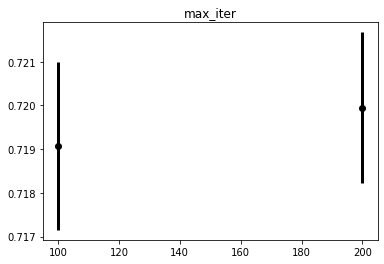

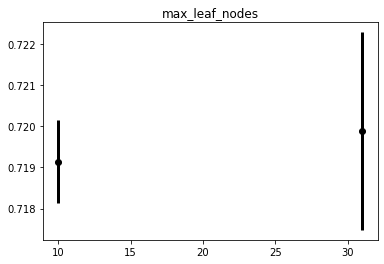

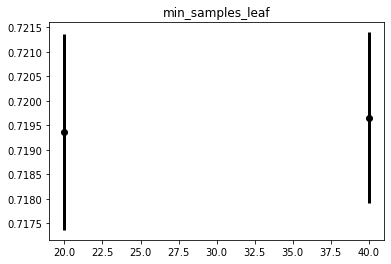

In [58]:
for param in df_scores_hgbt.params[0].keys():
    groups = df_scores_hgbt.groupby(param).mean_test_score
    means = groups.mean()
    stds = groups.std()
    plt.errorbar(means.index, means.values, stds.values, fmt='ok', lw=3);
    plt.title(param);
    plt.show();

- These are the average model performances for the various hyperparam settings

### Logistic Regression HP Tuning

In [59]:
# Create the parameter grid based on the results of random search 
logreg_params = {
    'l1_ratio': [0, .1, .5, 1.0]
    , 'C': [.1, .5, 1.0]
}

In [60]:
# Instantiate base models
logistic_model = LR(solver='saga', warm_start=True, n_jobs=-1, penalty='elasticnet')

In [61]:
%%time
# Instantiate the grid search models
grid_search_logistic = GridSearchCV(
    estimator=logistic_model, param_grid=logreg_params, 
    cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")
grid_search_logistic.fit(df_train, y_train)

Fitting 4 folds for each of 12 candidates, totalling 48 fits
CPU times: user 2.44 s, sys: 184 ms, total: 2.63 s
Wall time: 32.4 s


GridSearchCV(cv=4,
             estimator=LogisticRegression(n_jobs=-1, penalty='elasticnet',
                                          solver='saga', warm_start=True),
             n_jobs=-1,
             param_grid={'C': [0.1, 0.5, 1.0], 'l1_ratio': [0, 0.1, 0.5, 1.0]},
             scoring='accuracy', verbose=1)

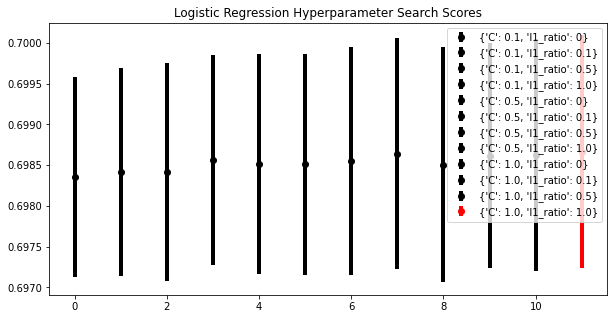

In [62]:
df_scores_logistic = pd.DataFrame(grid_search_logistic.cv_results_)

labels = np.arange(len(df_scores_logistic))
legend = [str(v) for v in df_scores_logistic.params.values]
stds = df_scores_logistic.std_test_score
means = df_scores_logistic.mean_test_score
ix_best_score = np.argmax(means)
plt.figure(figsize=(10,5));
for i in labels:
    if i == ix_best_score:
        plt.errorbar(labels[i], means[i], stds[i], fmt='or', lw=4)
    else:
        plt.errorbar(labels[i], means[i], stds[i], fmt='ok', lw=4)
plt.legend(legend);
plt.title('Logistic Regression Hyperparameter Search Scores');

In [63]:
logistic_params_star = {
    **df_scores_logistic.params[ix_best_score], 'solver':'saga'
    , 'warm_start':True, 'n_jobs':-1, 'penalty':'elasticnet'}
print(logistic_params_star)

{'C': 1.0, 'l1_ratio': 1.0, 'solver': 'saga', 'warm_start': True, 'n_jobs': -1, 'penalty': 'elasticnet'}


- Logistic regression seems robust to hyperparameters chosen.
    - All means within the variance of one another.
- Let's see if the same is true for the random forests.

### Random Forest HP Tuning

'''
Parameters
----------
n_estimators : int, default=100
    The number of trees in the forest.

criterion : {"gini", "entropy", "log_loss"}, default="gini"
    The function to measure the quality of a split. Supported criteria are
    "gini" for the Gini impurity and "log_loss" and "entropy" both for the
    Shannon information gain, see :ref:`tree_mathematical_formulation`.
    Note: This parameter is tree-specific.

max_depth : int, default=None
    The maximum depth of the tree. If None, then nodes are expanded until
    all leaves are pure or until all leaves contain less than
    min_samples_split samples.

min_samples_split : int or float, default=2
    The minimum number of samples required to split an internal node:

    - If int, then consider `min_samples_split` as the minimum number.
    - If float, then `min_samples_split` is a fraction and
      `ceil(min_samples_split * n_samples)` are the minimum
      number of samples for each split.
      
min_samples_leaf : int or float, default=1
    The minimum number of samples required to be at a leaf node.
    A split point at any depth will only be considered if it leaves at
    least ``min_samples_leaf`` training samples in each of the left and
    right branches.  This may have the effect of smoothing the model,
    especially in regression.

    - If int, then consider `min_samples_leaf` as the minimum number.
    - If float, then `min_samples_leaf` is a fraction and
      `ceil(min_samples_leaf * n_samples)` are the minimum
      number of samples for each node.
'''

In [65]:
%%time
tree_params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}
rfc_model = RandomForestClassifier(n_jobs=-1)
grid_search_rfc = GridSearchCV(
    estimator=rfc_model, param_grid=tree_params,
    cv=4, n_jobs=-1, verbose=1, scoring='accuracy')
grid_search_rfc.fit(df_train[:N], y_train[:N])

Fitting 4 folds for each of 50 candidates, totalling 200 fits
CPU times: user 3.57 s, sys: 157 ms, total: 3.72 s
Wall time: 1min 42s


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100]},
             scoring='accuracy', verbose=1)

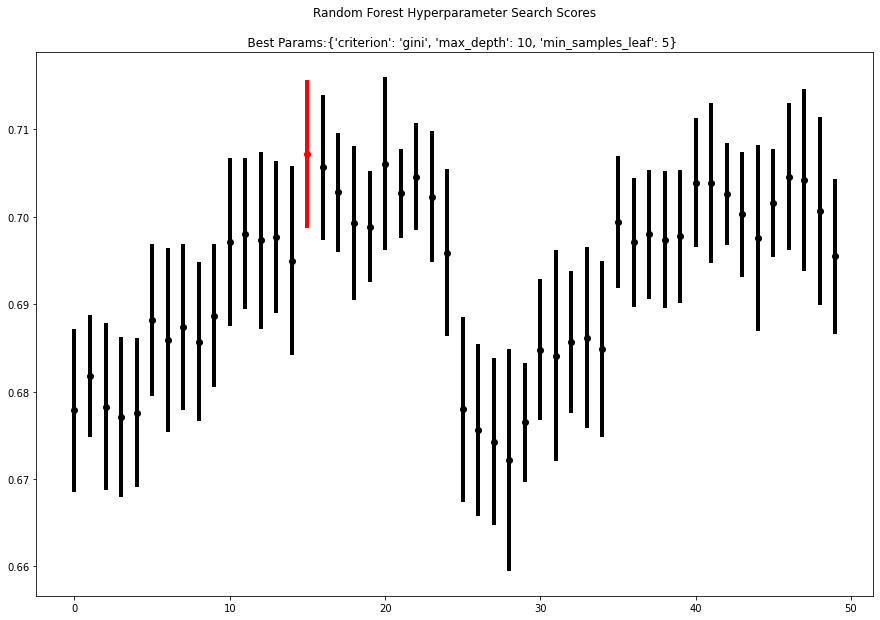

In [66]:
df_scores_rfc = pd.DataFrame(grid_search_rfc.cv_results_)

labels = np.arange(len(df_scores_rfc))
legend = [str(v) for v in df_scores_rfc.params.values]
stds = df_scores_rfc.std_test_score
means = df_scores_rfc.mean_test_score
ix_best_score = np.argmax(means)
plt.figure(figsize=(15,10));
for i in labels:
    if i == ix_best_score:
        plt.errorbar(labels[i], means[i], stds[i], fmt='or', lw=4)
    else:
        plt.errorbar(labels[i], means[i], stds[i], fmt='ok', lw=4)
# plt.legend(str(legend[ix_best_score]));
plt.title(f'''Random Forest Hyperparameter Search Scores\n
    Best Params:{legend[ix_best_score]}''');

- The same is not true for random forests
- Hyperparameter selection does make a significant impact on performance
- Let's identify which params mattered the most

In [67]:
df_scores_rfc = pd.concat([
    df_scores_rfc,
    pd.DataFrame.from_records(df_scores_rfc.params.values, index=df_scores_rfc.index)
], axis=1)

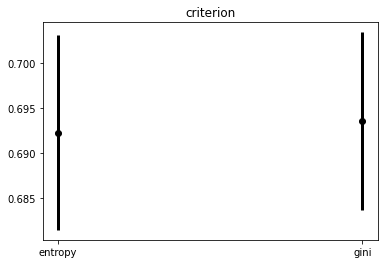

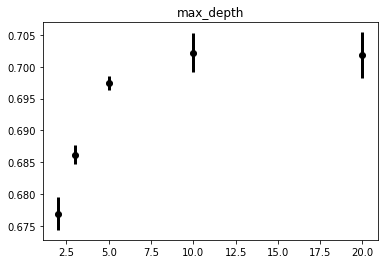

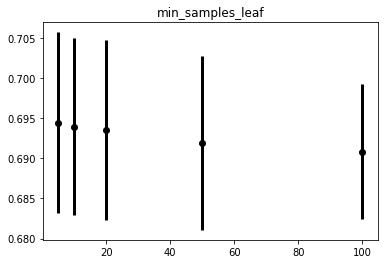

In [68]:
for param in df_scores_rfc.params[0].keys():
    groups = df_scores_rfc.groupby(param).mean_test_score
    means = groups.mean()
    stds = groups.std()
    plt.errorbar(means.index, means.values, stds.values, fmt='ok', lw=3);
    plt.title(param);
    plt.show();

- As we can see max_depth, matters more than the other two params.
- Let's do one more round, drilling down on max depth and incorporate max estimators as well

In [69]:
tree_params = {
    'max_depth': [7, 10, 12, 15], # new range from sweet-spot of chart above
    'n_estimators': [10, 100, 500],
    'min_samples_split': [.1, .3, .5]
}

In [70]:
grid_search_rfc = GridSearchCV(
    estimator=rfc_model, param_grid=tree_params,
    cv=4, n_jobs=-1, verbose=1, scoring='accuracy')

In [71]:
%%time
grid_search_rfc.fit(df_train[:N], y_train[:N])

Fitting 4 folds for each of 36 candidates, totalling 144 fits
CPU times: user 2.17 s, sys: 121 ms, total: 2.29 s
Wall time: 1min 29s


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'max_depth': [7, 10, 12, 15],
                         'min_samples_split': [0.1, 0.3, 0.5],
                         'n_estimators': [10, 100, 500]},
             scoring='accuracy', verbose=1)

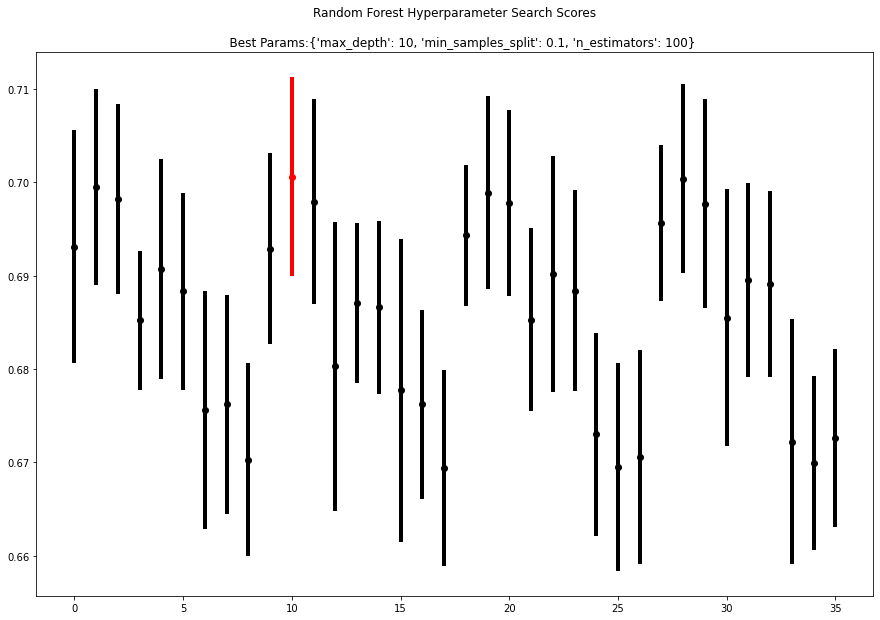

In [72]:
df_scores_rfc = pd.DataFrame(grid_search_rfc.cv_results_)

labels = np.arange(len(df_scores_rfc))
legend = [str(v) for v in df_scores_rfc.params.values]
stds = df_scores_rfc.std_test_score
means = df_scores_rfc.mean_test_score
ix_best_score = np.argmax(means)
plt.figure(figsize=(15,10));
for i in labels:
    if i == ix_best_score:
        plt.errorbar(labels[i], means[i], stds[i], fmt='or', lw=4)
    else:
        plt.errorbar(labels[i], means[i], stds[i], fmt='ok', lw=4)
plt.title(f'''Random Forest Hyperparameter Search Scores\n
    Best Params:{legend[ix_best_score]}''');

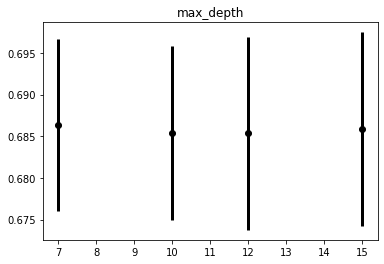

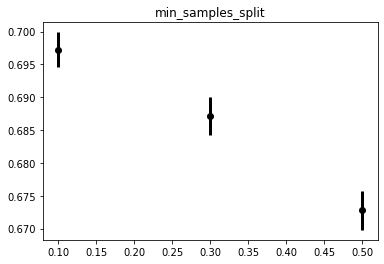

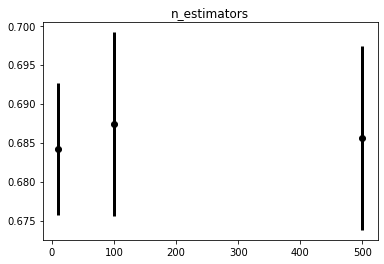

In [73]:
df_scores_rfc = pd.concat([
    df_scores_rfc,
    pd.DataFrame.from_records(df_scores_rfc.params.values, index=df_scores_rfc.index)
], axis=1)

for param in df_scores_rfc.params[0].keys():
    groups = df_scores_rfc.groupby(param).mean_test_score
    means = groups.mean()
    stds = groups.std()
    plt.errorbar(means.index, means.values, stds.values, fmt='ok', lw=3);
    plt.title(param);
    plt.show();

In [74]:
tree_params = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10],
    'criterion': ['gini'],
    'min_samples_split':[.1],
    'min_samples_leaf':[2]
}

In [75]:
grid_search_rfc = GridSearchCV(
    estimator=RandomForestClassifier(n_jobs=-1), param_grid=tree_params,
    cv=4, n_jobs=-1, verbose=1, scoring='accuracy')

In [76]:
%%time
grid_search_rfc.fit(df_train[:N], y_train[:N])

Fitting 4 folds for each of 3 candidates, totalling 12 fits
CPU times: user 1.74 s, sys: 71.1 ms, total: 1.81 s
Wall time: 13.9 s


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': [10],
                         'min_samples_leaf': [2], 'min_samples_split': [0.1],
                         'n_estimators': [100, 200, 500]},
             scoring='accuracy', verbose=1)

- Last round drilling down into n_estimators

In [77]:
df_scores_rfc = pd.DataFrame(grid_search_rfc.cv_results_)
dict(zip(df_scores_rfc.param_n_estimators, df_scores_rfc.mean_test_score))

{100: 0.6987, 200: 0.6975, 500: 0.6980000000000001}

- Performance seems to level off in the range of 100-200 estimators

### Rerun last gridsearch on an N of 100k (up from 10k)

In [78]:
tree_params = {
    'n_estimators': [100, 200, 500],
    'min_samples_leaf':[2, 3, 5]
}

In [79]:
grid_search_rfc = GridSearchCV(
    estimator=rfc_model, param_grid=tree_params,
    cv=4, n_jobs=-1, verbose=1, scoring='accuracy')

In [80]:
%%time
grid_search_rfc.fit(df_train[:100_000], y_train[:100_000])

Fitting 4 folds for each of 9 candidates, totalling 36 fits
CPU times: user 6min 38s, sys: 6.27 s, total: 6min 44s
Wall time: 25min 10s


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'min_samples_leaf': [2, 3, 5],
                         'n_estimators': [100, 200, 500]},
             scoring='accuracy', verbose=1)

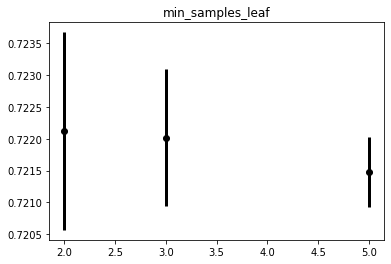

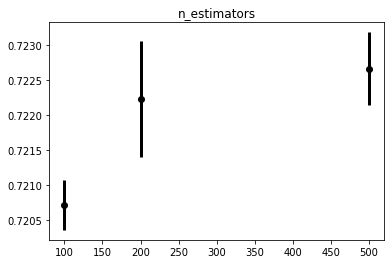

In [81]:
df_scores_rfc = pd.DataFrame(grid_search_rfc.cv_results_)

df_scores_rfc = pd.concat([
    df_scores_rfc,
    pd.DataFrame.from_records(df_scores_rfc.params.values, index=df_scores_rfc.index)
], axis=1)

for param in df_scores_rfc.params[0].keys():
    groups = df_scores_rfc.groupby(param).mean_test_score
    means = groups.mean()
    stds = groups.std()
    plt.errorbar(means.index, means.values, stds.values, fmt='ok', lw=3);
    plt.title(param);
    plt.show();

In [82]:
df_scores_rfc.mean_test_score.max()

0.72307

In [83]:
%%time
tree_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_leaf': [5],
}
rfc_model = RandomForestClassifier(n_jobs=-1)
grid_search_rfc = GridSearchCV(
    estimator=rfc_model, param_grid=tree_params,
    cv=2, n_jobs=-1, verbose=1, scoring='accuracy')
grid_search_rfc.fit(df_train[:N], y_train[:N])

Fitting 2 folds for each of 4 candidates, totalling 8 fits
CPU times: user 7.83 s, sys: 231 ms, total: 8.06 s
Wall time: 15.2 s


GridSearchCV(cv=2, estimator=RandomForestClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'max_depth': [10, 20], 'min_samples_leaf': [5],
                         'n_estimators': [100, 200]},
             scoring='accuracy', verbose=1)

In [84]:
pd.DataFrame(grid_search_rfc.cv_results_).mean_test_score.max()

0.7046

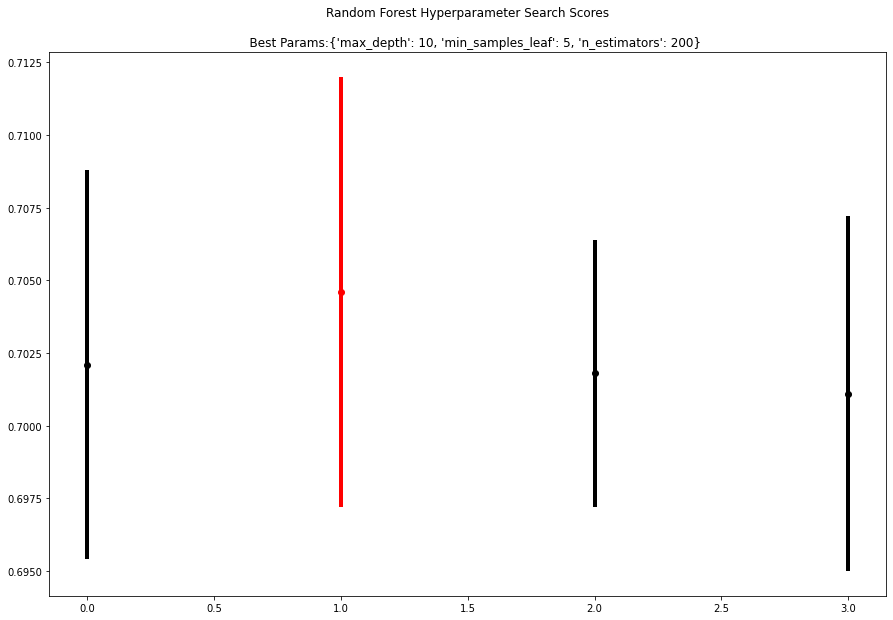

In [85]:
df_scores_rfc = pd.DataFrame(grid_search_rfc.cv_results_)

labels = np.arange(len(df_scores_rfc))
legend = [str(v) for v in df_scores_rfc.params.values]
stds = df_scores_rfc.std_test_score
means = df_scores_rfc.mean_test_score
ix_best_score = np.argmax(means)
plt.figure(figsize=(15,10));
for i in labels:
    if i == ix_best_score:
        plt.errorbar(labels[i], means[i], stds[i], fmt='or', lw=4)
    else:
        plt.errorbar(labels[i], means[i], stds[i], fmt='ok', lw=4)
# plt.legend(str(legend[ix_best_score]));
plt.title(f'''Random Forest Hyperparameter Search Scores\n
    Best Params:{legend[ix_best_score]}''');

In [86]:
%%time
rfc_model = RandomForestClassifier(n_jobs=-1, **df_scores_rfc.params[ix_best_score])
rfc_model.fit(df_train, y_train)
rfc_model.score(df_test, y_test)

CPU times: user 4min 5s, sys: 3.17 s, total: 4min 8s
Wall time: 1min 28s


0.7159659080799274

### RF HP Tuning Remarks
- This would be much less messy with more compute
- I tried to approximate a joint param grid search with a sequence of smaller searches b/c I'm doing this on a laptop with limited computing power

## Model Evaluation <a class="anchor" id="model-evaluation"></a>
- Use the results from grid search to compare model performances on the test set

In [87]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

In [88]:
def score_model(y_true, y_pred):
    p = 3 # precision
    cm = confusion_matrix(y_true, y_pred, normalize='all')
    acc = (y_true==y_pred).sum()/len(y_true)
    f1 = f1_score(y_true, y_pred)
    return {
          'accuracy': round(acc, p)
        , 'f1': round(f1, p)
        , 'confusion_matrix': pd.DataFrame(cm)
    }

In [89]:
best_hgbt_params

{'learning_rate': 0.1,
 'max_depth': None,
 'max_iter': 200,
 'max_leaf_nodes': 31,
 'min_samples_leaf': 20}

In [101]:
# "star" meaning optimal
hgbt_params_star = best_hgbt_params
print('hgbt params*', hgbt_params_star)

logreg_params_star = logistic_params_star
print('logreg params*', logreg_params_star)

rf_params_star = {
    'n_jobs':-1,
    'n_estimators': 500,
     'max_depth': 20,
    'criterion': 'gini',
    'min_samples_leaf': 5
}
print('rf_params*', rf_params_star)

hgbt params* {'learning_rate': 0.1, 'max_depth': None, 'max_iter': 200, 'max_leaf_nodes': 31, 'min_samples_leaf': 20}
logreg params* {'C': 1.0, 'l1_ratio': 1.0, 'solver': 'saga', 'warm_start': True, 'n_jobs': -1, 'penalty': 'elasticnet'}
rf_params* {'n_jobs': -1, 'n_estimators': 500, 'max_depth': 20, 'criterion': 'gini', 'min_samples_leaf': 5}


In [94]:
# Instantiate base models
hgbt_model = HGBT(**hgbt_params_star)
logistic_model = LR(**logreg_params_star)
rfc_model = RandomForestClassifier(**rf_params_star)

In [95]:
%%time
hgbt_model.fit(df_train, y_train)
hgbt_model.score(df_test, y_test)

CPU times: user 21.1 s, sys: 1.42 s, total: 22.5 s
Wall time: 7.73 s


0.7251650326506646

In [96]:
score_model(y_test, hgbt_model.predict(df_test))

{'accuracy': 0.725,
 'f1': 0.697,
 'confusion_matrix':           0         1
 0  0.409139  0.090230
 1  0.184605  0.316026}

In [97]:
%%time
logistic_model.fit(df_train, y_train)
logistic_model.score(df_test, y_test)

CPU times: user 2.74 s, sys: 56.7 ms, total: 2.8 s
Wall time: 2.68 s


0.6963221294994751

In [98]:
score_model(y_test, logistic_model.predict(df_test))

{'accuracy': 0.696,
 'f1': 0.685,
 'confusion_matrix':           0         1
 0  0.366364  0.133005
 1  0.170673  0.329959}

In [99]:
%%time
rfc_model.fit(df_train, y_train)
rfc_model.score(df_test, y_test)

/Users/six/envs/stacked/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/six/envs/stacked/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

CPU times: user 13min 22s, sys: 11 s, total: 13min 33s
Wall time: 4min 29s


0.729097347022295

In [100]:
score_model(y_test, rfc_model.predict(df_test))

{'accuracy': 0.729,
 'f1': 0.701,
 'confusion_matrix':           0         1
 0  0.411060  0.088308
 1  0.182595  0.318037}

### Model Evaluation Summary
- The Logistic Regression model provides good baseline accuracy of 70%.
- The LR model could also be extended to capture the non-normality of the independent variables.
- Both tree models (random forest and histogram boosted decision trees) achieve accuracies of ~73%.
- The random forest slightly outperforms and trades a point of false negatives for a point of false positives.
- Training times: LR trains in 3 sec, HGBT in 5 sec, RF in 1min 30sec.
- RF training time was the bottleneck, and could benefit from more compute resources.

# Summary Recap <a class="anchor" id="summary-recap"></a>
- Copying all of the summaries down here for quick reference

## Data Understanding Summary
- Dataset is long and skinny
- Appears normalized other than column 10, so normalize it.
- No missing values
- No all-zero columns
- Columns are *not* normally distributed
- No columnar colinearity
- Target correlations look well-formed

## Outlier Detection Summary
- Removing the outliers definitely helps unsquash the distributions

## Feature Selection Summary
- Identify the essential features in the dataset.
    - Top correlated and feature mean splits by target variable give a good indication, but this is ultimately decided by the top-performing models.
- What makes these features significant?
    - Discrete versions of the Oneway Anova F and Chi^2 tests agree they are each significant.
- How do they influence the outcome variable?
    - We saw the difference in feature means when the label == 0 vs label == 1.

## Feature Engineering Summary
- We created an augmented dataset from engineered features of the form f1*f2, f2*f3, f1^2, f2^2 ...etc
- We went from a baseline dataset performance of .709, down to an augmented dataset performance of .705.
- Augmentation did not increase performance of tree models.
- Augmentation only of slightly marginal benefit for linear models.

## Hyperparameter Tuning Summary
- We will make use of validation datasets in the form of *cross-validation* in this section.
- It will help us both optimize the hyperparamers while avoid overfitting to the training data.
- We will tune one tree and one linear model.
- Tuning will be done on a reduced N of 10k; testing will then be done on the full set with the optimal params.
- Logistic Regression model was largely robust to hyperparameter selection.
- RF model was most affected by the max_depth parameter, which we fine-tuned over two rounds.

## Model Selection Summary
- Going with the random forest and logistic regression models due to:
    1. Have the highest overall performance
    2. Maintain performance in low-data regimes (r^2 of ~.70(rand forest and logreg) vs .43(gbt) on 10k samples)
2. Will become important in the next section on hyperparameter tuning.

## Model Evaluation Summary
- The Logistic Regression model provides good baseline accuracy of 70%.
- The LR model could also be extended to capture the non-normality of the independent variables.
- Both tree models (random forest and histogram boosted decision trees) achieve accuracies of ~73%.
- The random forest slightly outperforms and trades a point of false negatives for a point of false positives.
- Training times: LR trains in 3 sec, HGBT in 5 sec, RF in 1min 30sec.
- RF training time was the bottleneck, and could benefit from more compute resources.

# Communication

- Overall this appeared to be a pretty straitforward modeling excercise where:
    - the data was mostly pre-cleaned, but a bit more helped,
    - multiple different models were able to pick up on the patterns in the data,
    - we fine-tuned a few models and analyzed the results,
    - obtained a 73% accuracy on the hold-out set
    - could possibly improve this by using more compute resources.

- Future modeling iterations would involve better accounting for the non-normality of the input data and more extensive hyper-param search.